In [6]:
%load_ext autoreload
%autoreload 2

import os
import sys
import time
import random
import json
import gc

import numpy as np
import pandas as pd
import torch
import h5py
from ipywidgets import interact
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import nibabel as nib
from einops import rearrange
from scipy import ndimage
from fracridge import FracRidgeRegressorCV

dir2 = os.path.abspath('../..')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: 
    sys.path.append(dir1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load a clip model
import clip
device = "cuda" if torch.cuda.is_available() else "cpu"

print(clip.available_models())
model_name = 'ViT-B/32'
full_model, preprocess = clip.load(model_name, device=device)
model = full_model.visual

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


In [3]:
from research.data.things_dataset import ThingsDataset

import torchvision.transforms as T
import torch.nn.functional as F

things_path = Path("X:\\Datasets\\EEG\\Things-concepts-and-images\\")
derivatives_path = Path('X:\\Datasets\\EEG\\Things-supplementary')
similarity_path = Path('X:\\Datasets\\EEG\\Things-similarity')

things_dataset = ThingsDataset(
    root=things_path,
    transform=preprocess,
    #supplementary_path="X:\\Datasets\\EEG\\Things-supplementary\\",
    #latent_name="bigbigan-resnet50",
)

In [4]:
nsd_path = Path('D:\\Datasets\\NSD\\')
results_path = nsd_path / f'derivatives/figures/things'
results_path.mkdir(exist_ok=True, parents=True)

In [ ]:
with h5py.File(Path(derivatives_path) / f'{model_name.replace("/", "=")}.hdf5', 'a') as f:
    N = len(things_dataset)
    E = 512
    dset = f.require_dataset('embedding', (N, E), np.float32)
    for i in tqdm(range(N)):
        image = things_dataset[i]['data']
        image = image[None].to(torch.float16)
        with torch.no_grad():
            embedding = model(image.to(device)).cpu().numpy()
        dset[i] = embedding[0]

In [7]:
import scipy.io as sio
im_mat = sio.loadmat(similarity_path / 'variables' / 'im.mat')

In [ ]:
im_mat['im'][0

In [ ]:
im_mat.keys()
plt.imshow(im_mat['im'][0][0])

In [11]:
clip_embeddings = h5py.File(Path(derivatives_path) / f'ViT-B=32.hdf5', 'r')['embedding'][:]

In [12]:
clip_concept_embeddings = np.stack([
    clip_embeddings[things_dataset.image_concept_ids == i].mean(axis=0)
    for i in np.unique(things_dataset.image_concept_ids)
])
clip_concept_embeddings = clip_concept_embeddings / np.linalg.norm(clip_concept_embeddings, axis=1)[:, None]

In [ ]:
clip_concept_embeddings

In [8]:
things_embeddings = np.loadtxt(similarity_path / 'data' / 'spose_embedding_49d_sorted.txt')

In [13]:
from fracridge import FracRidgeRegressorCV
from sklearn.linear_model import LinearRegression, PoissonRegressor, RidgeCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split

Y = things_embeddings.astype(np.float32)
X = clip_concept_embeddings
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

model = RidgeCV(fit_intercept=False)
model.fit(X_train, Y_train)
Y_test_pred = model.predict(X_test)
model.score(X_test, Y_test)

0.530591322956637

In [ ]:
Y_pred = model.predict(X_test)

In [14]:
@interact(i=(0, 48))
def show(i):
    plt.hist(Y_test_pred[:, i], bins=50)
    plt.show()

interactive(children=(IntSlider(value=24, description='i', max=48), Output()), _dom_classes=('widget-interact'…

In [ ]:
things_embeddings.min()

In [ ]:
Y_pred.shape

In [19]:
from research.metrics.metrics import r2_score, pearsonr




In [15]:
things_concepts = [
    'made of metal, artificial, hard', 
    'food-related, eating-related, kitchen-related',
    'animal-related, organic',
    'clothing-related, fabric, covering',
    'furniture-related, household-related, artifact',
    'plant-related, green',
    'outdoors-related',
    'transportation, motorized, dynamic',
    'wood-related, brownish',
    'body part-related',
    'colorful',
    'valuable, special occasion-related',
    'electronic, technology',
    'sport-related, recreational activity-related',
    'disc-shaped, round',
    'tool-related',
    'many small things, course pattern',
    'paper-related, thin, flat, text-related',
    'fluid-related, drink-related',
    'long, thin',
    'water-related, blue',
    'powdery, fine-scale pattern',
    'red',
    'feminine (stereotypically), decorative',
    'bathroom-related, sanitary',
    'black, noble',
    'weapon, danger-related, violence',
    'musical instrument-related, noise-related',
    'sky-related, flying-related, floating-related',
    'spherical, ellipsoid, rounded, voluminous',
    'repetitive',
    'flat, patterned',
    'white',
    'thin, flat',
    'disgusting, bugs',
    'string-related',
    'arms/legs/skin-related',
    'shiny, transparent',
    'construction-related, physical work-related',
    'fire-related, heat-related',
    'head-related, face-related',
    'beams-related',
    'seating-related, put things on top',
    'container-related, hollow',
    'child-related, toy-related',
    'medicine-related',
    'has grating',
    'handicraft-related',
    'cylindrical, conical'
]

things_concepts2 = [c.replace('-related', '') for c in things_concepts]

with torch.no_grad():
    W_things = full_model.encode_text(clip.tokenize(things_concepts).to(device))
W_things = W_things.cpu().numpy()

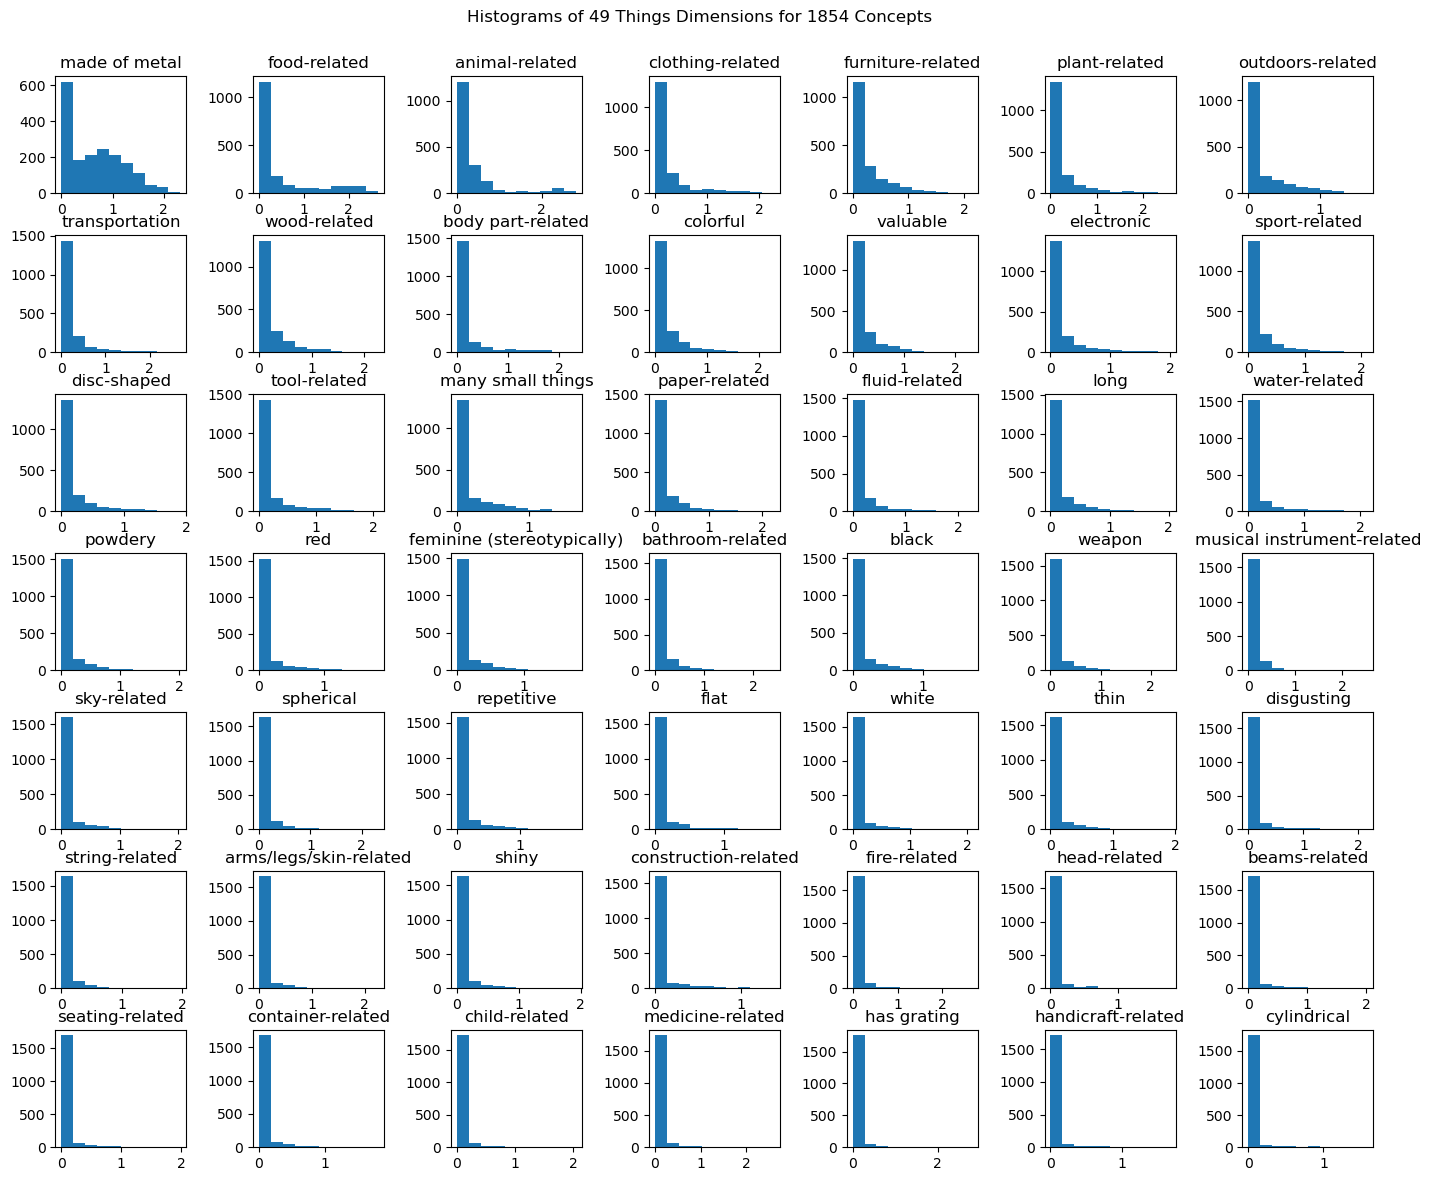

In [16]:
# R^2 histograms

fig, ax = plt.subplots(nrows=7, ncols=7, figsize=(14, 12), )
ax = ax.flatten()
fig.tight_layout()
fig.subplots_adjust(top=0.925,)

for i, things_concept in enumerate(things_concepts):
    ax[i].hist(Y[:, i])
    ax[i].set_title(things_concept.split(',')[0])


fig.suptitle('Histograms of 49 Things Dimensions for 1854 Concepts')
#fig.supxlabel('R^2')
#fig.supylabel('Number of Dimensions')
file_name = 'things_dimension_histograms.png'
plt.savefig(results_path / file_name, pad_inches=0)
plt.show()

In [ ]:
W_things.shape

In [20]:
r2_score(torch.from_numpy(Y), torch.from_numpy(X @ W_things.T), reduction=None)

tensor([ -13.2035,   -7.2766,  -11.7379,  -20.9985,  -43.3405,  -24.1037,
         -49.0628,  -30.9323,  -40.0332,  -29.6494,  -30.0630,  -59.7215,
         -47.9330,  -64.6813,  -46.6827,  -46.6079,  -55.2744,  -49.6378,
         -47.4915,  -58.5235,  -35.6478,  -91.4511,  -48.1377,  -98.8923,
         -73.5229,  -82.3988,  -85.5165,  -88.9228,  -72.5632,  -68.2684,
        -143.8897,  -97.6374,  -74.0986, -120.1009, -106.3948,  -92.6957,
         -75.7329, -113.5515, -152.0503, -112.0883, -128.3278, -117.1203,
        -156.4854, -154.5825, -163.7714, -213.5224, -158.4238, -244.2084,
        -240.4433])

In [ ]:
.shape

In [ ]:
model.alpha_

In [21]:
hidden_size = 500

torch_model = torch.nn.Sequential(
    torch.nn.Linear(X.shape[1], Y.shape[1]),
    #torch.nn.LeakyReLU(),
    #torch.nn.Dropout(p=0.9),
    #torch.nn.Linear(hidden_size, hidden_size),
    #torch.nn.LeakyReLU(),
    #torch.nn.Dropout(p=0.9),
    #torch.nn.Linear(hidden_size, Y.shape[1]),
    torch.nn.ReLU()
)
torch_model = torch_model.cuda()

with torch.no_grad():
    torch_model[0].weight[:] = torch.from_numpy(model.coef_)

optim = torch.optim.Adam(torch_model.parameters(), lr=0.00001,)
criterion = torch.nn.MSELoss()

num_iterations = 5000
for i in range(num_iterations):
    torch_model.train()
    
    Y_train_pred = torch_model(torch.from_numpy(X_train).cuda())
    loss = criterion(torch.from_numpy(Y_train).cuda(), Y_train_pred)
    loss.backward()
    optim.step()
    
    if i % 250 == 0 or i == (num_iterations - 1):
        with torch.no_grad():
            torch_model.eval()
            
            torch_r = pearsonr(
                torch.from_numpy(Y_test).cuda(), 
                torch_model(torch.from_numpy(X_test).cuda()), 
                reduction=None
            )
            print(i, torch_r.mean().cpu().item())

0 0.7312630865410774
250 0.7326647570035076
500 0.7342167734636738
750 0.7356871521687052
1000 0.73690348178832
1250 0.7374459365197497
1500 0.7377108352264676
1750 0.7381235793693509
2000 0.7386618926148597
2250 0.7391798838614608
2500 0.740154401805569
2750 0.7410718114676748
3000 0.7418091636478361
3250 0.7425751513847272
3500 0.743520291092951
3750 0.7443353621446361
4000 0.7448565040062942
4250 0.7452147997620795
4500 0.7454702118174219
4750 0.7456627879540895
4999 0.7461061621579571


In [22]:
torch_model = torch_model.cpu()
with torch.no_grad():
    torch_model.eval()
    torch_r = pearsonr(torch.from_numpy(Y_test), torch_model(torch.from_numpy(X_test)), reduction=None)
    print(torch_r)

tensor([0.9087, 0.9697, 0.9695, 0.9172, 0.8888, 0.9081, 0.8534, 0.9427, 0.7473,
        0.8497, 0.7337, 0.8224, 0.9223, 0.8947, 0.7446, 0.8797, 0.6481, 0.8115,
        0.9102, 0.7180, 0.8325, 0.7726, 0.4635, 0.7219, 0.7116, 0.5609, 0.8463,
        0.8050, 0.8626, 0.7395, 0.7498, 0.6369, 0.4047, 0.5686, 0.8598, 0.7539,
        0.6907, 0.6370, 0.7376, 0.7371, 0.7351, 0.6964, 0.6332, 0.5351, 0.7225,
        0.7212, 0.5539, 0.4662, 0.3630], dtype=torch.float64)


In [23]:
r = pearsonr(torch.from_numpy(Y_test), torch.from_numpy(model.predict(X_test)), reduction=None)

In [24]:
print((torch_r - r).tolist())

[0.002260289164797813, 0.002366650037451401, 0.0035633800509432545, 0.007200189038986671, 0.005411301961035897, 0.010489763583079292, 0.013504635132384979, 0.007265713218542191, 0.018083515503225622, 0.009239296907627925, 0.01420234547482091, 0.016539550270030068, 0.015237111971704964, 0.010874501629611122, 0.020130429602580047, 0.016432244451268008, 0.0058167110631539565, 0.012754992384668484, 0.010678845575724738, 0.023702271167439948, 0.013229101579643077, 0.030473070514196454, 0.020593958059846318, 0.027512728597141267, 0.04386508897020036, 0.022773718932098563, 0.026989679257145238, 0.017484396111533074, 0.027166403184794574, 0.023780360415762813, 0.03329136255896181, 0.026599460524260876, 0.01682284353522473, 0.041486193206547006, 0.025116673379238286, 0.05899476600647857, 0.026733240514182466, 0.05678080787970097, 0.037055676156047546, 0.051776332655119384, 0.03022893828029538, 0.04309369336649349, 0.02757914838548081, 0.03016439505892987, 0.04166433451808038, 0.0640051596444876

In [25]:
r.mean(), torch_r.mean()

(tensor(0.7222, dtype=torch.float64), tensor(0.7461, dtype=torch.float64))

In [28]:
results_path

WindowsPath('D:/Datasets/NSD/derivatives/figures/things')

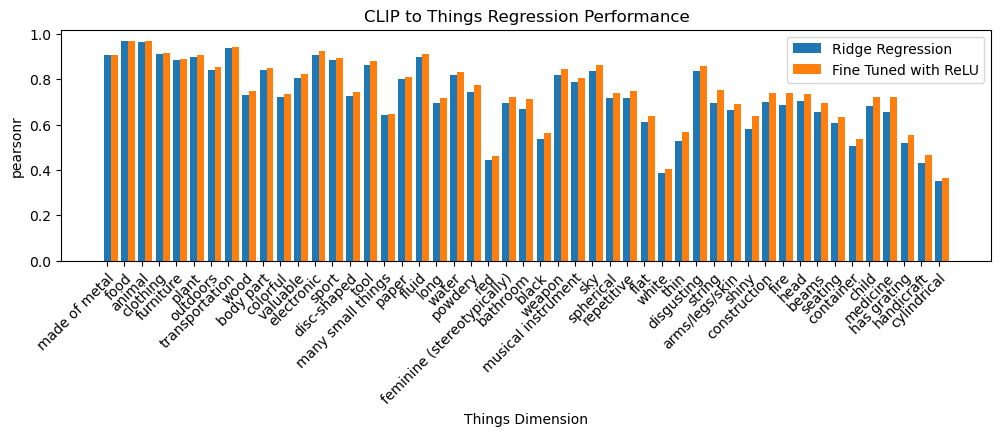

In [36]:
width = 0.4
plt.figure(figsize=(12, 3))
plt.title("CLIP to Things Regression Performance")
plt.xlabel("Things Dimension")
plt.ylabel("pearsonr")
plt.bar(np.arange(49), r, 
        tick_label=[c.split(',')[0].replace('-related', '') for c in things_concepts], 
        width=width,
        label='Ridge Regression',)
plt.bar(np.arange(49) + width, torch_r, width=width, label='Fine Tuned with ReLU')
plt.legend()
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.savefig(results_path / 'clip_to_things_r.png', bbox_inches='tight')
plt.savefig(results_path / 'clip_to_things_r.svg', bbox_inches='tight')
plt.show()

In [160]:
ridge_weights = model.coef_
torch_weights = torch_model[0].weight[:].cpu().detach().numpy()

np.save(nsd_path / 'derivatives/things/ridge_weights.npy', ridge_weights)
np.save(nsd_path / 'derivatives/things/torch_weights.npy', torch_weights)

In [ ]:
np.save(nsd_path / 'derivatives/things/ridge_weights.npy', ridge_weights)
np.save(nsd_path / 'derivatives/things/torch_weights.npy', torch_weights)